In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

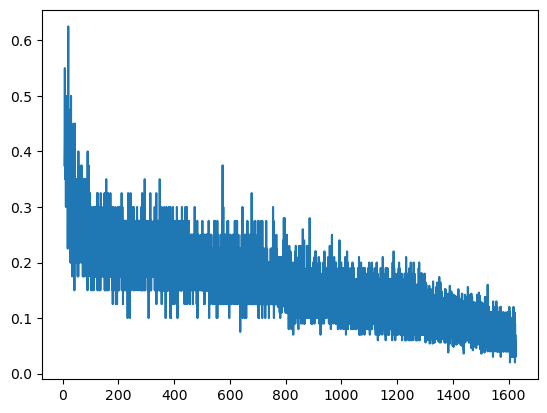

In [54]:
grip_thinning = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/GRIP/thinning.txt', sep='\t', comment = '#')
ngrip_thinning = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/NGRIP/thinning.txt', sep='\t', comment = '#')

load_gicc05 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05_time_scale.tab', sep='\t', comment = '#', skiprows=40)

grip_accumulation = pd.DataFrame()
#take the thickness of each year first
grip_accumulation['thick'] = load_gicc05['Depth ice/snow [m] (GRIP)'].diff() 
grip_accumulation['depth']= load_gicc05['Depth ice/snow [m] (GRIP)']
grip_accumulation.dropna(inplace=True)  # Remove NaN values resulting from diff()

grip_accumulation = grip_accumulation.dropna(subset=['thick'])

plt.plot(grip_accumulation['depth'], grip_accumulation['thick'])

In [55]:
load_gicc05 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05_time_scale.tab', sep='\t', comment = '#', skiprows=40)
load_gicc05['Depth ice/snow [m] (GRIP)'].max()

1624.27

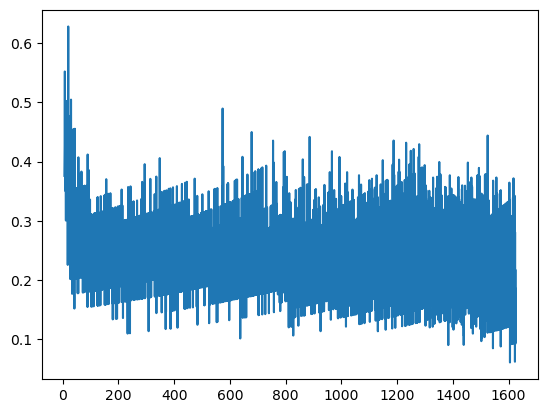

In [ ]:
# acc = thickness / thinning factor
grip_accumulation['thinning'] = np.interp(grip_accumulation['depth'], grip_thinning['depth'], grip_thinning['thinning'])

grip_accumulation['accumulation'] = grip_accumulation['thick'] / grip_accumulation['thinning']

plt.plot(grip_accumulation['depth'], grip_accumulation['accumulation'])



In [74]:
grip_accumulation.rename(columns={
    'accumulation': 'deporate'
}, inplace=True)

grip_accumulation['rel_unc'] = grip_accumulation['deporate'] * 0.1

grip_accumulation['comment'] = np.nan

grip_accumulation_export = grip_accumulation[['depth', 'deporate', 'rel_unc', 'comment']]

grip_accumulation_export.to_csv('/Users/quinnmackay/Desktop/temp/deporate.txt', sep='\t', index=False)